## Name: Adeyemi Olutosin Funmilayo
## Student ID: 202502853

In [174]:
!pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable


In [175]:
# importing libaries
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import os
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import SGD
import keras_tuner as kt

In [200]:
# Load the CSV
image_dir = "/Users/funmilayoadeyemi/MSc/Understanding AI Final Assignment /CNN/archive/train/train/images"  
data = pd.read_csv("/Users/funmilayoadeyemi/MSc/Understanding AI Final Assignment /CNN/archive/train/train/train.csv")

# Preview the first few rows
data.head()

,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5


In [202]:
# Define label mapping for damage classification
label_mapping = {
    1: 'crack',
    2: 'scratch',
    3: 'tire flat',
    4: 'dent',
    5: 'glass shatter',
    6: 'lamp broken'
}

# Extract damage class names for easy reference
damage_classes = list(label_mapping.values())


In [203]:
# Load images and labels into NumPy arrays
def load_images(df, img_dir):
    images, labels = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['filename'])
        img = cv2.imread(img_path)
        img = cv2.resize(img, (32, 32))
        images.append(img)
        # subtract 1 so labels go from 0–5 rather than 1–6
        labels.append(row['label'] - 1)
    return np.array(images), np.array(labels)

# Apply the function
x, y = load_images(data, image_dir)


In [204]:
# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.20,    # 20% test split
    stratify=y,        # preserve class proportions
    random_state=42    # reproducible
)


In [205]:
# Print the shape of each array
print("x_train shape is:", x_train.shape)   # e.g. (n_train, 32, 32, 3)
print("x_test shape is: ", x_test.shape)    # e.g. (n_test,  32, 32, 3)
print("y_train shape is:", y_train.shape)   # (n_train,)
print("y_test shape is: ", y_test.shape)    # (n_test,)


x_train shape is: (5760, 32, 32, 3)
x_test shape is:  (1440, 32, 32, 3)
y_train shape is: (5760,)
y_test shape is:  (1440,)


In [206]:
# Normalize pixel values to the [0,1] range
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0


In [207]:
# Set up data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True,   
    vertical_flip=False,    
    shear_range=0.10,       
    zoom_range=0.10         
)

# Fit the generator on the training data
train_datagen.fit(x_train)


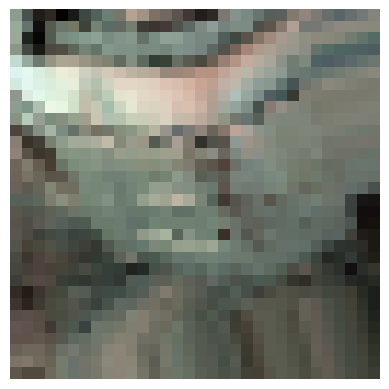

In [208]:
#  Visualize a random augmented image
augmented_img = train_datagen.random_transform(x_train[0])

import matplotlib.pyplot as plt
plt.imshow(augmented_img)
plt.gca().axis("off")
plt.show()


In [209]:
# Build the CNN model

model = Sequential()

# Input: 32×32 RGB images
model.add(Input(shape=(32, 32, 3)))

# Conv block 1: 32 filters, 3×3 kernels, ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Conv block 2: 64 filters, 3×3 kernels
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Conv block 3: 128 filters, 3×3 kernels
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer: one unit per damage class
model.add(Dense(len(damage_classes), activation='softmax'))

# Display model architecture
model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,774 (878.02 KB)

 Trainable params: 224,774 (878.02 KB)

 Non-trainable params: 0 (0.00 B)

In [210]:
# Compile the model

model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/20


/Users/funmilayoadeyemi/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3054 - loss: 1.6189 - val_accuracy: 0.3271 - val_loss: 1.5399
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3336 - loss: 1.5383 - val_accuracy: 0.3917 - val_loss: 1.4473
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3511 - loss: 1.4875 - val_accuracy: 0.4076 - val_loss: 1.4122
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3945 - loss: 1.4097 - val_accuracy: 0.4319 - val_loss: 1.3109
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3870 - loss: 1.4024 - val_accuracy: 0.4493 - val_loss: 1.2584
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4369 - loss: 1.3170 - val_accuracy: 0.4271 - val_loss: 1.3107
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4315 - loss: 1.3471 - val_accuracy: 0.4993 - val_loss: 1.1980
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4565 - loss: 1.2600 - val_accuracy: 0.507

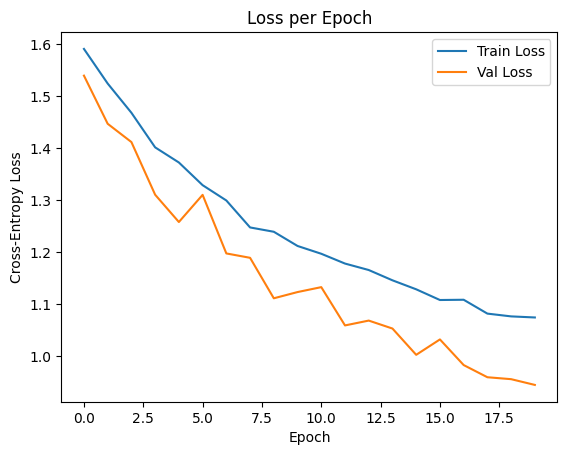

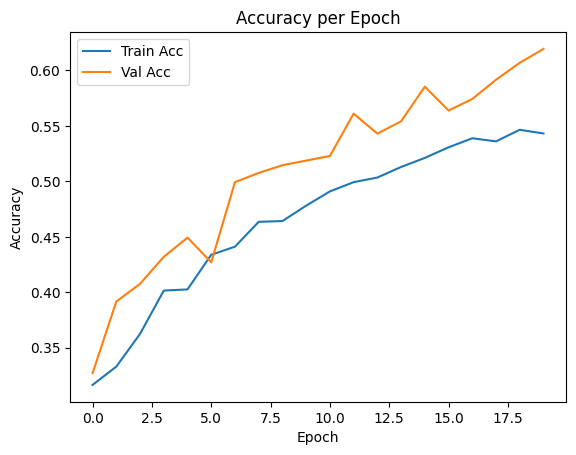

In [211]:
# Train the model and plot training curves

history = model.fit(
    train_datagen.flow(
        x_train,
        to_categorical(y_train, num_classes=len(damage_classes)),
        batch_size=32
    ),
    epochs=20,
    validation_data=(
        x_test,
        to_categorical(y_test, num_classes=len(damage_classes))
    )
)

import matplotlib.pyplot as plt

# Loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.show()

# Accuracy curves
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


               precision    recall  f1-score   support

        crack       0.00      0.00      0.00        34
      scratch       0.64      0.57      0.60       470
    tire flat       0.78      0.87      0.82       107
         dent       0.49      0.54      0.52       416
glass shatter       0.80      0.82      0.81       237
  lamp broken       0.55      0.62      0.58       176

     accuracy                           0.62      1440
    macro avg       0.54      0.57      0.56      1440
 weighted avg       0.61      0.62      0.61      1440



/Users/funmilayoadeyemi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/funmilayoadeyemi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/funmilayoadeyemi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

<Figure size 2000x3000 with 0 Axes>

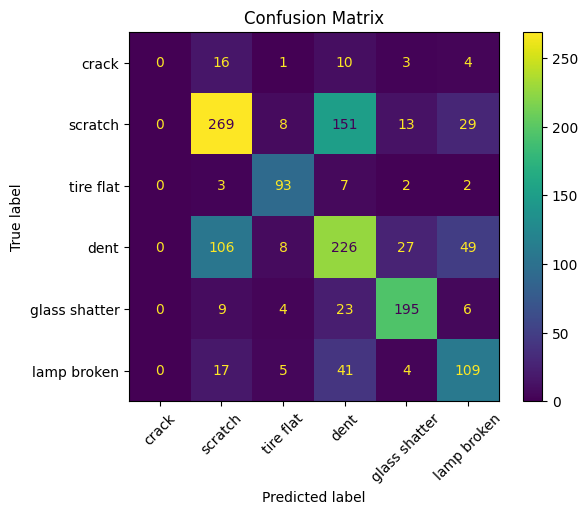

In [214]:
# Classification report + confusion matrix

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Human-readable class names in label order (0–5)
class_names = ["crack", "scratch", "tire flat", "dent", "glass shatter", "lamp broken"]

# Show precision/recall/F1 for each class
print(classification_report(y_test, y_pred_labels, target_names=class_names))

# Plot confusion matrix
plt.figure(dpi=200, figsize=(10, 15))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_labels,
    display_labels=class_names
)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()


## Hyperparameter Search to Boost Accuracy
We’ll use **Keras-Tuner** to explore different network sizes, dropout rates, and learning rates to maximize validation accuracy.


In [215]:
# Imports & Model Builder
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)

def build_tunable_model(hp):
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))

    # Three convolutional blocks with tunable filters & optional batchnorm
    filter_options = [32, 64, 96]
    for i in range(3):
        f = hp.Choice(f"filters_block_{i+1}", filter_options, default=filter_options[i])
        model.add(Conv2D(f, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        if hp.Boolean(f"use_batchnorm_{i+1}", default=True):
            model.add(BatchNormalization())

    model.add(Flatten())
    # Tunable dense layer
    units = hp.Choice("dense_units", [64, 128, 256], default=64)
    model.add(Dense(units, activation='relu'))

    # Tunable dropout
    dropout_rate = hp.Float("dropout_rate", 0.2, 0.6, step=0.1, default=0.4)
    model.add(Dropout(dropout_rate))

    # Output layer: one unit per damage class
    model.add(Dense(len(damage_classes), activation='softmax'))

    # Compile with tunable learning rate
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling='log', default=1e-3)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [216]:
# Initialize Tuner & EarlyStopping
from tensorflow.keras import callbacks

tuner = kt.RandomSearch(
    build_tunable_model,
    objective='val_accuracy',
    max_trials=12,
    executions_per_trial=1,
    directory='hp_tuning',
    project_name='vehicle_damage'
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


Reloading Tuner from hp_tuning/vehicle_damage/tuner0.json


In [217]:
# Data Augmentation Setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_params = {
    'rotation_range': 15,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'zoom_range': 0.1,
    'shear_range': 0.08,
    'horizontal_flip': True
}

train_datagen = ImageDataGenerator(**datagen_params)
train_datagen.fit(x_train)


In [218]:
# Run Hyperparameter Search
# Prepare one-hot labels
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=len(damage_classes))
y_test_cat  = to_categorical(y_test,  num_classes=len(damage_classes))

tuner.search(
    train_datagen.flow(x_train, y_train_cat, batch_size=64),
    epochs=15,
    validation_data=(x_test, y_test_cat),
    callbacks=[early_stop]
)


In [219]:
# Retrieve Best Hyperparameters & Build Final Model
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

print("Best hyperparameters:")
print(f" Filters block 1: {best_hp.get('filters_block_1')}")
print(f" Filters block 2: {best_hp.get('filters_block_2')}")
print(f" Filters block 3: {best_hp.get('filters_block_3')}")
print(f" BatchNorm flags: {[best_hp.get(f'use_batchnorm_{i+1}') for i in range(3)]}")
print(f" Dense units:      {best_hp.get('dense_units')}")
print(f" Dropout rate:     {best_hp.get('dropout_rate'):.2f}")
print(f" Learning rate:    {best_hp.get('learning_rate'):.5f}")

best_model.summary()


Best hyperparameters:
 Filters block 1: 32
 Filters block 2: 32
 Filters block 3: 96
 BatchNorm flags: [False, False, True]
 Dense units:      192
 Dropout rate:     0.20
 Learning rate:    0.00097


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 96)       │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 192)            │       295,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,534 (1.28 MB)

 Trainable params: 334,342 (1.28 MB)

 Non-trainable params: 192 (768.00 B)

In [220]:
# Retrain Best Model & Evaluate
history_best = best_model.fit(
    train_datagen.flow(x_train, y_train_cat, batch_size=64),
    epochs=20,
    validation_data=(x_test, y_test_cat),
    callbacks=[early_stop]
)

val_loss, val_acc = best_model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Validation accuracy (best model): {val_acc:.3f}")


Epoch 1/20


/Users/funmilayoadeyemi/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3466 - loss: 1.5881 - val_accuracy: 0.4410 - val_loss: 1.7070
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4920 - loss: 1.2318 - val_accuracy: 0.4882 - val_loss: 1.6017
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5238 - loss: 1.1504 - val_accuracy: 0.5118 - val_loss: 1.5116
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5225 - loss: 1.1016 - val_accuracy: 0.5125 - val_loss: 1.3407
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5726 - loss: 1.0159 - val_accuracy: 0.5583 - val_loss: 1.2386
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5955 - loss: 0.9743 - val_accuracy: 0.5465 - val_loss: 1.0847
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6178 - loss: 0.9347 - val_accuracy: 0.5715 - val_loss: 1.0491
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6286 - loss: 0.9099 - val_accuracy: 0.6021 - val_loss: 0.

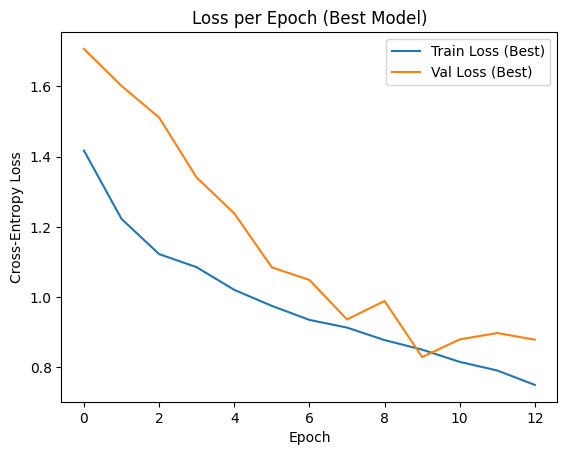

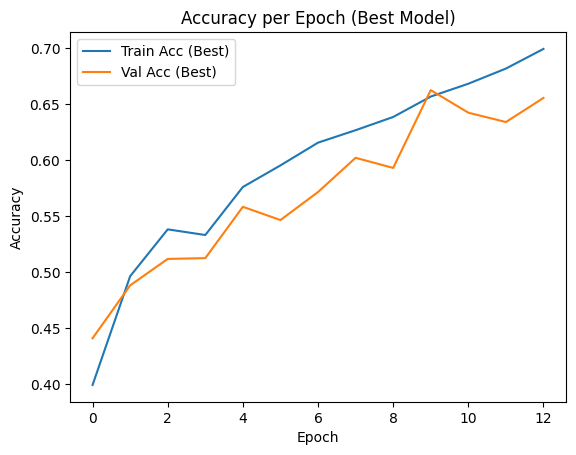

In [223]:
# Plot loss and accuracy for the best model from hyperparameter tuning
import matplotlib.pyplot as plt

# Loss curves
plt.plot(history_best.history['loss'],     label='Train Loss (Best)')
plt.plot(history_best.history['val_loss'], label='Val Loss (Best)')
plt.title('Loss per Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.show()

# Accuracy curves
plt.plot(history_best.history['accuracy'],     label='Train Acc (Best)')
plt.plot(history_best.history['val_accuracy'], label='Val Acc (Best)')
plt.title('Accuracy per Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
               precision    recall  f1-score   support

        crack       0.67      0.06      0.11        34
      scratch       0.64      0.70      0.67       470
    tire flat       0.80      0.91      0.85       107
         dent       0.61      0.50      0.55       416
glass shatter       0.75      0.88      0.81       237
  lamp broken       0.59      0.63      0.61       176

     accuracy                           0.66      1440
    macro avg       0.68      0.61      0.60      1440
 weighted avg       0.66      0.66      0.65      1440



<Figure size 800x600 with 0 Axes>

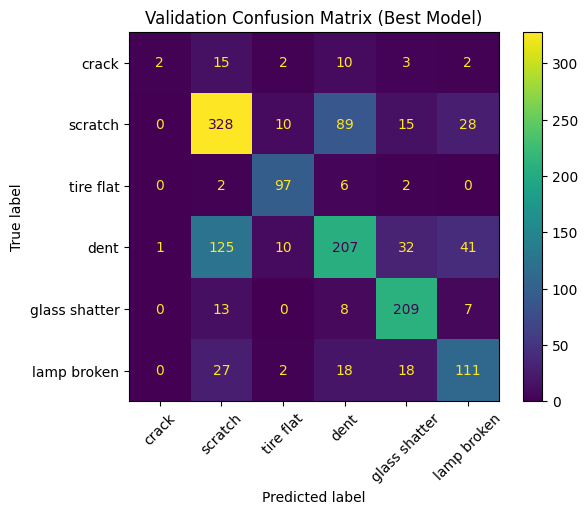

In [224]:
# Predictions & Confusion Matrix
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds      = np.argmax(best_model.predict(x_test), axis=1)
true_vals  = np.argmax(y_test_cat, axis=1)
damage_labels = damage_classes  # same human-readable labels

print(classification_report(true_vals, preds, target_names=damage_labels))

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    true_vals,
    preds,
    display_labels=damage_labels
)
plt.title('Validation Confusion Matrix (Best Model)')
plt.xticks(rotation=45)
plt.show()
